<h1>Numba-LEGACY-SINTEL-nonmixed-lines</h1><br>


##Configuring notebook if it is run in google colab

In [1]:
colab = False
try:
  from google.colab import drive
  drive.mount("/content/gdrive")
  colab = True
  %cd '/content/gdrive/My Drive/python_projects/FYP'
except Exception:
  pass

##Importing necessary libraries

In [7]:
import numpy as np
from components.classes.NumbaSimpleMatcher import Wrapper as m
from components.classes.SimpleProgressBar import SimpleProgressBar

from components.utils import utils as u
import imp
import cv2
import os
import matplotlib.pyplot as plt
import gc
from components.classes.CSVWriter2 import Wrapper as l
from components.classes.Metrix import Wrapper as me
from components.classes.SintelReader import Wrapper as SintelReader
import math
import time
import glob

##Configuring and testing data generator

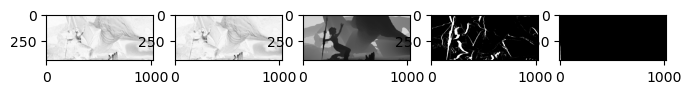

File ./optimization/2/numba_legacy/legacy_stacked_images_5_256.csv already exists, header has not been written.


In [8]:
ROOT_DATA_SRC = "./optimization/2"
LOG_DIRECTORY = ROOT_DATA_SRC+"/numba_legacy/"
CSV_FILE_NAME =  "legacy_stacked_images_5_256.csv"
CSV_FILE_PATH = os.path.join(LOG_DIRECTORY, CSV_FILE_NAME)


path = "./datasets/sintel/training"
reader = SintelReader(rootPath=path)
#reader.print_available_scenes()
reader.set_selected_scene('cave_4')
loaded_imgs = reader.get_selected_scene_next_files()
SintelReader.plot_images_to_compare(loaded_imgs)

log = l(file_path = CSV_FILE_PATH)
progress_bar = SimpleProgressBar.get_instance()

##Matcher visual and metrical testing

> Indented block



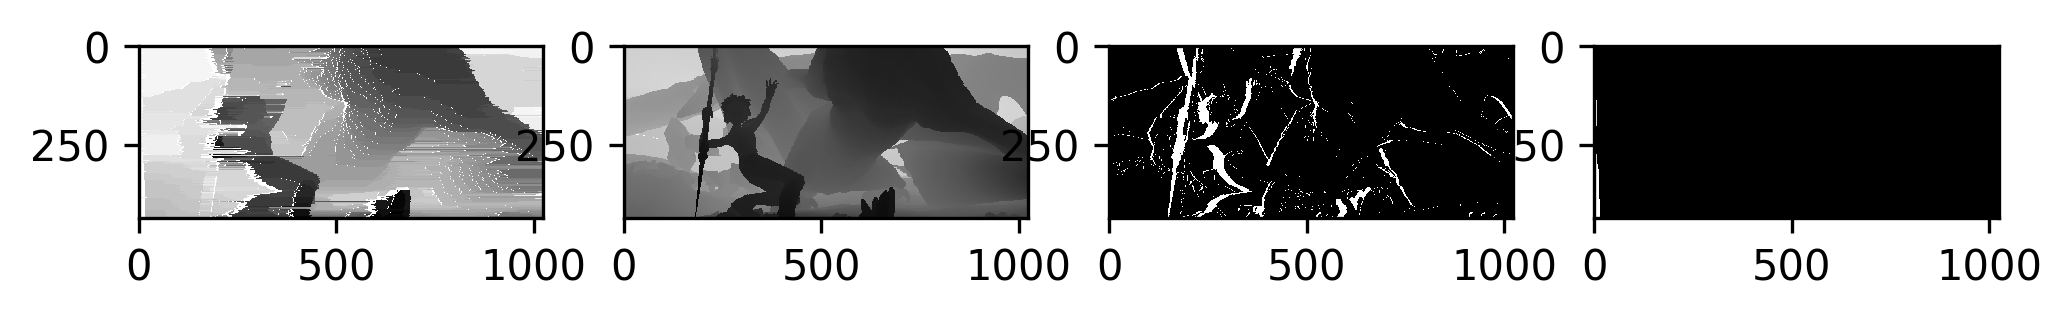

[148.31887901376146, 26067737947.59633, 105352.52274150819]


In [10]:
m_score, gap_score, egap_score = 60, -20, -1
matcher = m(m_score, gap_score, egap_score)
    
matcher.set_images(loaded_imgs[1], loaded_imgs[0])  
matcher.configure_instance()      
x,raw_disp_map = matcher.run_pipeline()

SintelReader.plot_images_to_compare([raw_disp_map, loaded_imgs[2], loaded_imgs[3], loaded_imgs[4]])

disp_modified = SintelReader.add_masks_to_raw_disparity(loaded_imgs[2],loaded_imgs[3], loaded_imgs[4])
ABS_ERR = me.avgerr(raw_disp_map, disp_modified)
mse = me.mse(raw_disp_map, disp_modified)
euclid = me.eucledian_distance(raw_disp_map, disp_modified)

print([ABS_ERR, mse, euclid])

##Initialising loop parameters

In [11]:
ORIGINAL_IMG_DIM = loaded_imgs[0].shape
STARTING_ROW_FOR_SLICES = 0
ROW_HEIGHT_PER_SLICE = ORIGINAL_IMG_DIM[0]
NUMBER_OF_COLUMNS = int(ORIGINAL_IMG_DIM[1]/4)
SCENES = reader.get_available_scenes()


SLICE_DIM = [ROW_HEIGHT_PER_SLICE, NUMBER_OF_COLUMNS]

main_temp = []
for i in range(5):
  reader.set_selected_scene(SCENES[int(i*3)])
  temp = reader.get_selected_scene_next_sliced(SLICE_DIM, starting_row = 0)
  temp = np.array(temp)
  main_temp.append(temp)

optimizer_img = np.hstack(main_temp)


print(optimizer_img.shape)



spec_dict = dict({})
spec_dict["is_parallel"] = "True"
spec_dict["img_name"] = "sintel_stacked_multiple_256"
spec_dict["alg_type"] =  "simle_numba_matcher_avg"
spec_dict["is_img_preprocessed"] = "False"
spec_dict["convolution_filters"] = "-"
spec_dict["filter_strategy"] = "-"
spec_dict["matching_mode"] = non_occ =  "occlusions_added_to_the_groundtruth"
spec_dict["matrix_init_mode"] = 2


loop_params = {}
loop_params["match"] = {"start": 150, "end":-10, "step":-10}
loop_params["gap"] = {"start":0, "end":-100, "step":-10}
loop_params["egap"] = {"start":10, "end":-100, "step":-10}

number_of_iterations = 1

for v in loop_params.values():
  temp = math.ceil(abs((v["start"]-v["end"])/v["step"]))
  print(temp)
  number_of_iterations *= temp

number_of_iterations =number_of_iterations * 1
print("The number of iterations based on the params: {0}".format(round(number_of_iterations)))

(5, 2180, 256)
16
10
11
The number of iterations based on the params: 1760


##Running the optimisation

In [0]:
progress_counter = 1
for m_score in range(loop_params["match"]["start"], loop_params["match"]["end"], loop_params["match"]["step"]):
    for gap_score in range(loop_params["gap"]["start"], loop_params["gap"]["end"], loop_params["gap"]["step"]):
        for egap_score in range(loop_params["egap"]["start"], loop_params["egap"]["end"], loop_params["egap"]["step"]):
            
            spec_dict["matrix_init_mode"] = 2
            match = spec_dict["match"] = m_score
            gap = spec_dict["gap"] = gap_score
            egap = spec_dict["egap"] = egap_score


            matcher = m(m_score, gap_score, egap_score)
    
            matcher.set_images(optimizer_img[1], optimizer_img[0])  
            matcher.configure_instance()      
            tic=time.time()

            x,raw_disp_map = matcher.run_pipeline()
            toc = time.time()

            gt_occluded = SintelReader.add_masks_to_raw_disparity(optimizer_img[2], optimizer_img[3], optimizer_img[4])


            wanna_print = False
            spec_dict["runtime"] = toc-tic
            spec_dict["mse"] = me.mse(raw_disp_map, gt_occluded)
            spec_dict["euclid_distance"] =me.eucledian_distance(raw_disp_map, gt_occluded)
            spec_dict["ABS_ERR"] = me.avgerr(raw_disp_map, gt_occluded, print=wanna_print, non_occ = True)

            progress_bar.progress_bar(progress_counter, number_of_iterations, header= "Parameter search progress: ", progress_bar_steps=100)
            progress_counter+=1
            log.append_new_sm_results(spec_dict)

Parameter search progress:  [>>>>------------------------------------------------------------------------------------------------] 4.15 % completed: 73 / 1760 steps

##Visualising and analysing results

In [0]:
import pandas as pd
results_data_frame = pd.read_csv(CSV_FILE_PATH)
results_data_frame.columns = [str.strip(col) for col in results_data_frame.columns]

results_data_frame.describe()


In [0]:
results_data_frame.sort_values(by="ABS_ERR").head()

In [0]:
top_5_config = results_data_frame.sort_values(by="ABS_ERR").head()
top_5_config = top_5_config[["match", "gap", "egap"]].values

optimizer_img = reader.get_selected_scene_next_files()

for params in top_5_config:
  matcher = m(params[0], params[1], params[2])

  matcher.set_images(optimizer_img[1], optimizer_img[0])  
  matcher.configure_instance()      
  x,raw_disp_map = matcher.run_pipeline()
  plt.subplot(121)
  plt.imshow(raw_disp_map)
  plt.subplot(122)
  plt.imshow(optimizer_img[2])
  plt.show()

In [0]:
top_5_config = results_data_frame.sort_values(by="mse").head()
top_5_config = top_5_config[["match", "gap", "egap"]].values

optimizer_img = reader.get_selected_scene_next_files()

for params in top_5_config:
  matcher = m(params[0], params[1], params[2])

  matcher.set_images(optimizer_img[1], optimizer_img[0])  
  matcher.configure_instance()      
  x,raw_disp_map = matcher.run_pipeline()
  plt.subplot(121)
  plt.imshow(raw_disp_map)
  plt.subplot(122)
  plt.imshow(optimizer_img[2])
  plt.show()


In [0]:
top_5_config = results_data_frame.sort_values(by="euclid_distance").head()
top_5_config = top_5_config[["match", "gap", "egap"]].values

optimizer_img = reader.get_selected_scene_next_files()

for params in top_5_config:
  matcher = m(params[0], params[1], params[2])

  matcher.set_images(optimizer_img[1], optimizer_img[0])  
  matcher.configure_instance()      
  x,raw_disp_map = matcher.run_pipeline()
  plt.subplot(121)
  plt.imshow(raw_disp_map)
  plt.subplot(122)
  plt.imshow(optimizer_img[2])
  plt.show()


In [0]:
#slice and dice data here please, also, ensure that the ABS_ERRor is converted to float64
x_axis = "match"
y_axis = "gap"
z_axis = "egap"
metrix ="ABS_ERR"
plu.plotly_3d_results(x_axis, y_axis, z_axis, metrix, results_data_frame)

In [0]:
#slice and dice data here please, also, ensure that the ABS_ERRor is converted to float64
x_axis = "match"
y_axis = "gap"
z_axis = "egap"
metrix ="mse"
plu.plotly_3d_results(x_axis, y_axis, z_axis, metrix, results_data_frame)

In [0]:
#slice and dice data here please, also, ensure that the ABS_ERRor is converted to float64
x_axis = "match"
y_axis = "gap"
z_axis = "egap"
metrix ="euclid_distance"
plu.plotly_3d_results(x_axis, y_axis, z_axis, metrix, results_data_frame)